 #### J. Souza and E. Bruning, Assessment of turbulence intensity in different spots of lightning flash propagation. Submitted to Geophysical Reserach Letters

#### CONTENTS:
#### 1. READ DATA FROM TABLES
#### 2. MAIN RESULT
#### 3. READ RADAR AND LIGHTNING DATA 
#### 4. CALCULATE EDR AND VELOCITY DERIVATIVES FROM INITIAL DATASET
#### 5. FIND THE CLOSEST SOURCE: "INTERCEPTED LOCATION"
#### 6. VISUALIZE SOURCES FROM INDIVIDUAL FLASHES
#### 7. RETRIEVE RESULTS
#### 8. VISUALIZE INDIVIDUAL RESULTS

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLine2D
import matplotlib as mpl

import xarray as xr
from datetime import datetime, date, time, timedelta
import glob
import scipy as sp
from scipy.spatial.transform import Rotation 
import pyart
import pytda
import os
import cartopy.crs as ccrs
from functools import partial

# Functions
from radarlma2local import geo_to_tps
from select_lma import one_flash
from plot_radar import plot_locs_lma_rhi, plot_RHI_EDR_panel,plot_EDR_dVR, plot_sources_interp
from ortho_proj import rot_mat_lma, closest_pt_radarloc, close_sources
from radar_processing import dealias_range_elev_derivatives, r_z_centers_edges_mesh
from interp_funcs import centers_to_edges_1d, coords_2d, oban, barnes, weighted_mean, weighted_std, interp_avg_std

# From LMA tools
from lmatools.io.LMA_h5_file import LMAh5File
from coordinateSystems import RadarCoordinateSystem, GeographicSystem, TangentPlaneCartesianSystem


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# from zipfile import ZipFile
# # -- Unzip the folders with the radar and lightning data 
# lightning_file = 'lightning.zip'
# radar_file = 'radar.zip'
# with ZipFile(lightning_file, 'r') as zip: 
#     zip.printdir() 
#     zip.extractall() 
# with ZipFile(radar_file, 'r') as zip: 
#     zip.printdir() 
#     zip.extractall() 

### 1. READ DATA TABLES

In [3]:
# -- Reading tables
data_nn = pd.read_csv('./turbulence_table_nearestneighbor.csv')
data_oban1 = pd.read_csv('./turbulence_table_objectiveanalysis1.csv')
data_oban2 = pd.read_csv('./turbulence_table_objectiveanalysis2.csv')

### 2. MAIN RESULT

/home/jessica/ktal/paper/plot_radar.py:148: RuntimeWarning: divide by zero encountered in log10
  c = np.log10(table.area.values),


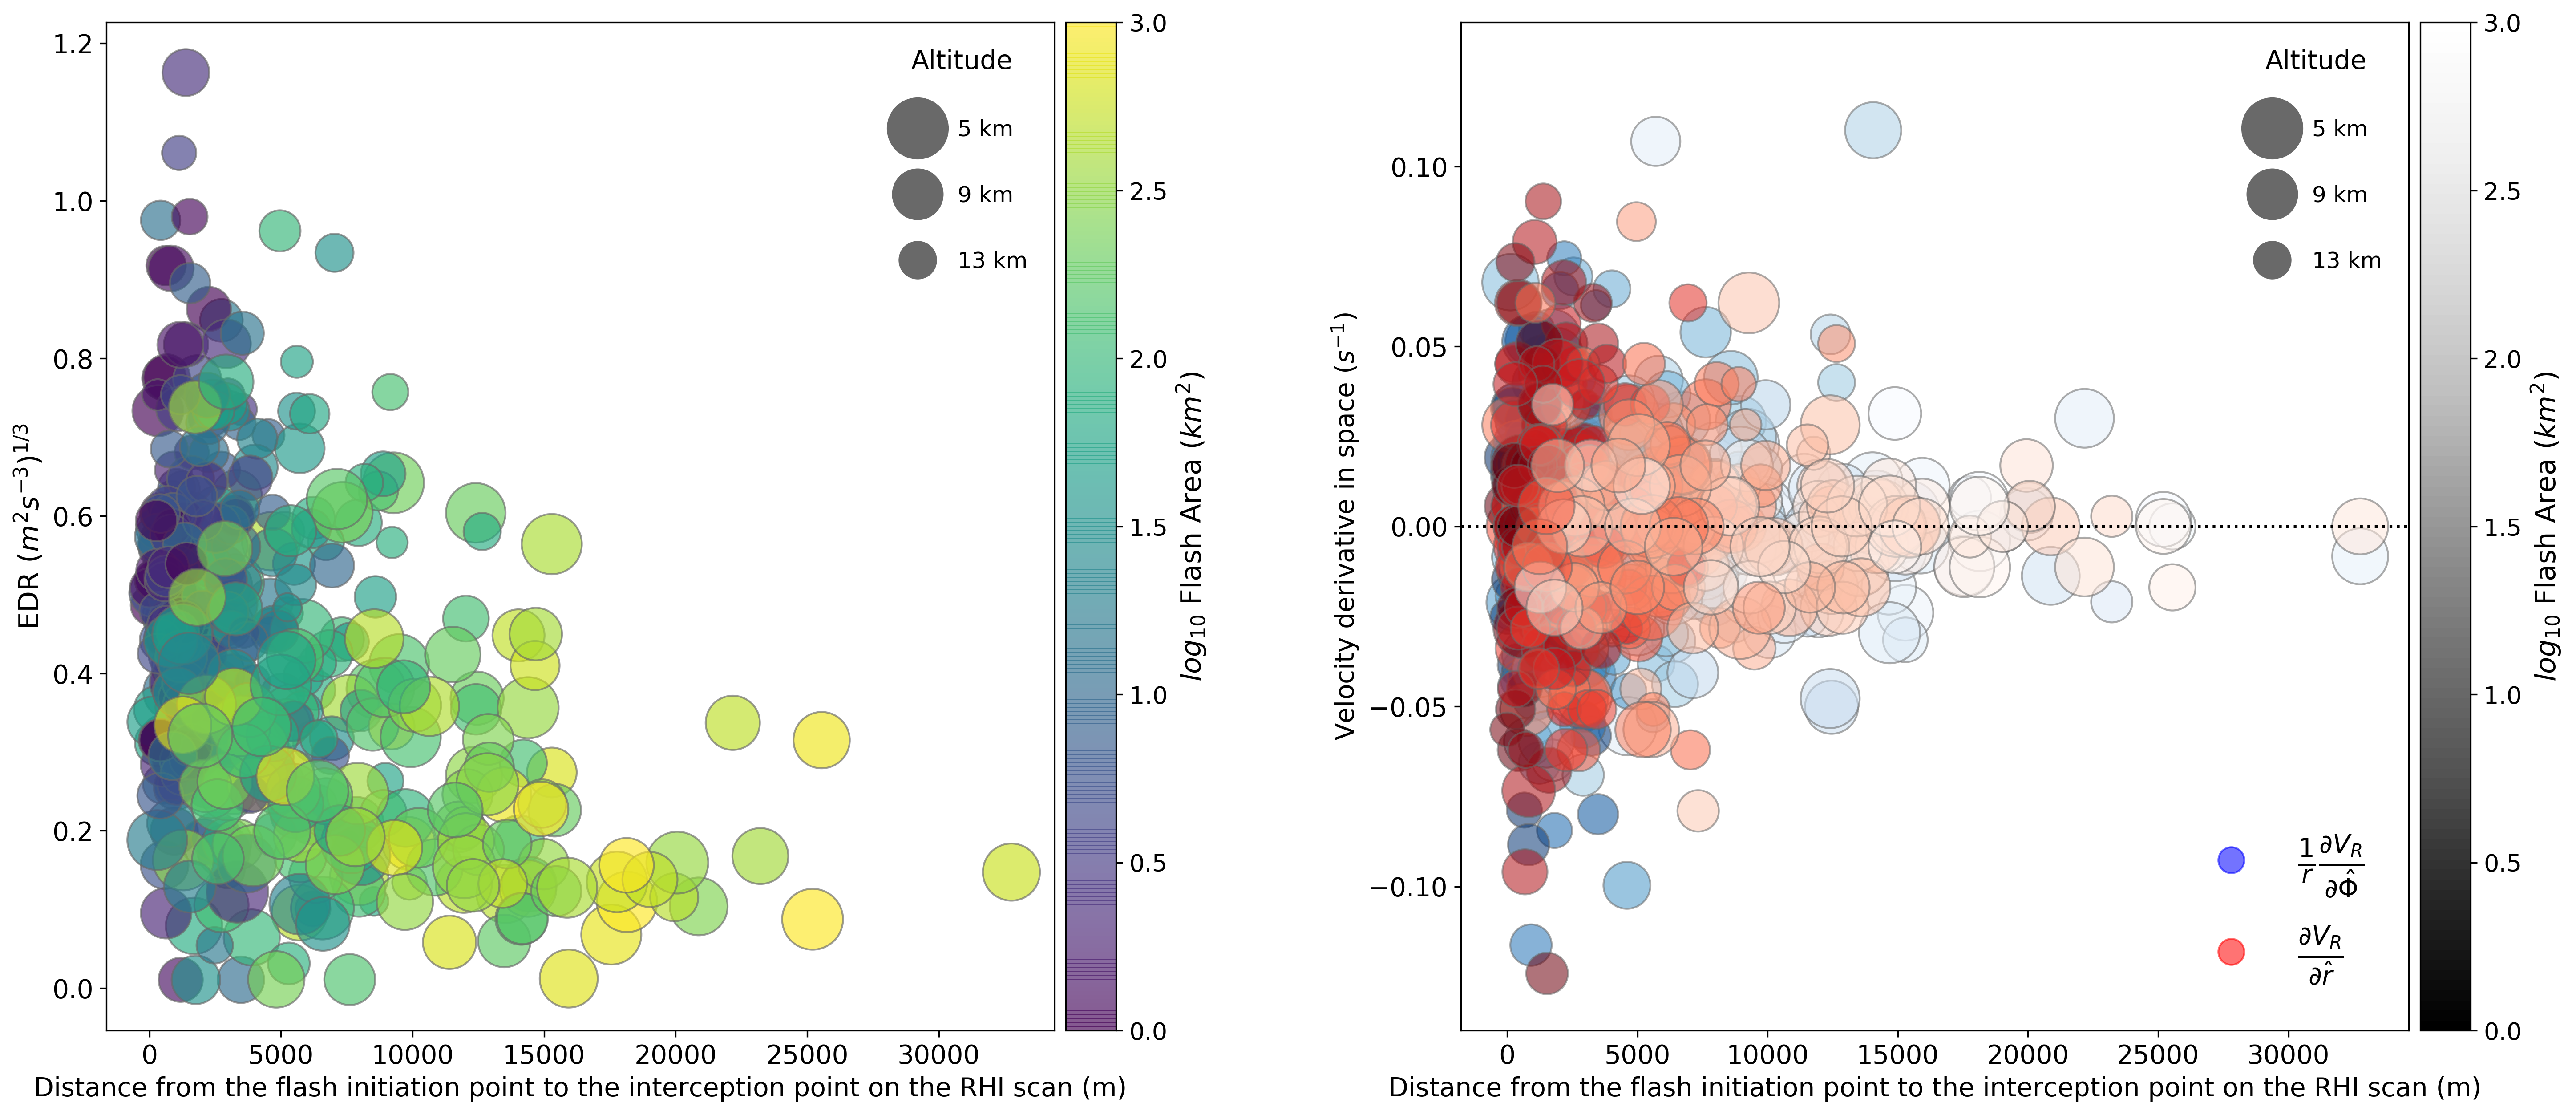

In [4]:
# - Figure 2
plot_EDR_dVR(data_nn)

### 3. READ RADAR AND LIGHTNING DATA 

In [5]:
# -- Choose table
table = data_nn

# -- The index from different flashes go up to 443 in data_nn, 404 in data_oban1 and 347 in data_oban2.
k = 106

lma_base = table.lma_base.values[k]
arq_ka = table.arq_ka[k]
flashes_id = table.flash_id.values

In [6]:
# -- LIGHTNING
lma = LMAh5File(lma_base)
events, flashes = lma.data_for_table(lma.table_names[0])
flashes = pd.DataFrame(flashes)
events = pd.DataFrame(events)
events = events[events.alt < 16000.][events.stations > 5][events.chi2 < 5.]
potential = events

[datetime.datetime(2015, 7, 10, 22, 40)] ['LMA_150710_224000_600'] {'LMA_150710_224000_600': {'start_time': datetime.datetime(2015, 7, 10, 22, 40), 'start_date': datetime.datetime(2015, 7, 10, 0, 0)}}
data for table dt = {0} 0.0


/home/jessica/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


### 4. CALCULATE EDR AND VELOCITY DERIVATIVES FROM INITIAL DATASET

In [7]:
# -- RADAR
radar = pyart.io.read_cfradial(arq_ka)
# -- Creating EDR field parameter
gate_spacing = radar.range['meters_between_gates']/1000.
beamwidth = radar.instrument_parameters['radar_beam_width_h']['data'][0]
pytda.calc_turb_rhi(radar, verbose = False, use_ntda=False, beamwidth=beamwidth, gate_spacing=gate_spacing)

# -- Adding dealias velocity, dVRdr, dVRde fields to radar file
import warnings
warnings.simplefilter("ignore")
radar = dealias_range_elev_derivatives(radar)

arq_tur = './radar/turb_' + os.path.split(arq_ka)[1]
# .nc export
try:
    os.remove(arq_tur)
except OSError:
    pass
pyart.io.cfradial.write_cfradial(arq_tur, radar,format='NETCDF4')

# -- Get radar time
d = date(int(radar.time['units'][14:18]),int(radar.time['units'][19:21]),int(radar.time['units'][22:24]))
t = time(int(radar.time['units'][25:27]),int(radar.time['units'][28:30]),int(radar.time['units'][31:33]))
radar_time = datetime.combine(d,t)
print(radar_time)

/home/jessica/anaconda3/lib/python3.7/site-packages/pyart/io/cfradial.py:365: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]
/home/jessica/anaconda3/lib/python3.7/site-packages/pyart/io/cfradial.py:365: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]
/home/jessica/anaconda3/lib/python3.7/site-packages/pytda-1.1.1-py3.7-linux-x86_64.egg/pytda/rsl_tools.py:32: RuntimeWarning: invalid value encountered in arccos
  gr = Re * np.arccos((Re**2 + h**2 - slant_r**2) / (2.0 * Re * h))
/home/jessica/anaconda3/lib/python3.7/site-packages/pytda-1.1.1-py3.7-linux-x86_64.egg/pytda/pytda.py:706: RuntimeWarning: divide by zero encountered in log10
  snr_sw = dz_sw + 20.0 * np.log10(230.0 / sw_sr)
/home/jessica/anaconda3/lib/python3.7/site-packages/pytda-1.1.1-py3.7-linux-x86_64.egg/pytda/pytda.py:435: RuntimeWarning: divide by zero encountered in true_divide
  z = 

2015-07-10 22:47:36


### 5. FIND CLOSEST SOURCES: "INTERCEPTED LOCATION"

![interp_calc.png](interp_calc.png)

In [8]:
# -- Radar scan processing
data = xr.open_dataset(arq_tur)
RZ_centers, RZ_edges = r_z_centers_edges_mesh(data, 0)
# -- WITH THIS I'M ONLY TAKING 1 SWEEP IF I WANT MORE OR ALL I UNCOMMENT THE BELLOW LINES BUT IT TAKES A LONG TIME
# for sweep_idx in np.arange(1, len(data.sweep_start_ray_index)):
#     centers, edges = r_z_centers_edges_mesh(data, sweep_idx)
#     RZ_centers = np.append(RZ_centers, centers, axis = 0)
#     RZ_edges = np.append(RZ_edges, edges, axis = 0)
r_c = RZ_centers[:,:,0]
z_c = RZ_centers[:,:,1]
r_e = RZ_edges[:,:,0]
z_e = RZ_edges[:,:,1]

# -- To filter VHF sources out of the radar scan domain
# --- Create the polygon: all ranges, lowest and highest elevation
# --- ~ 23 km (IDX 221), 23.5 km (IDX 165)range all elevations
# RZ_edges[:, - 165]
from shapely.geometry import Polygon, Point, MultiPoint
scan_poly = Polygon(np.append(np.append(RZ_edges[-1, :-221],RZ_edges[0, :-221], axis = 0), RZ_edges[:, - 221], axis = 0))

# -- FLASH
# --- Select the flash #k
flash = one_flash(potential, flashes_id[k])
flash = flash.sort_values(by=['time'])

# --- Orthogonal projection/ Matrix Rotation of the LF sources
Xlma,Ylma,Zlma = geo_to_tps(flash, radar)
XYZlma = np.column_stack((Xlma, Ylma, Zlma))
lma_file_ortho = rot_mat_lma(radar, XYZlma, -1)

# -- Initialize coordinate systems
ctrlat, ctrlon, ctralt = data.latitude.values, data.longitude.values, data.altitude.values
geo = GeographicSystem()
tps = TangentPlaneCartesianSystem(ctrlat, ctrlon, ctralt)
rcs = RadarCoordinateSystem(ctrlat, ctrlon, ctralt)

# -- First source location in the cross section
alt_lma_init = flashes.init_alt[flashes.flash_id == flash.flash_id.values[0]].values[0]
lat_lma_init = flashes.init_lat[flashes.flash_id == flash.flash_id.values[0]].values[0]
lon_lma_init = flashes.init_lon[flashes.flash_id == flash.flash_id.values[0]].values[0]
m = rot_mat_lma(radar, np.column_stack(tps.toLocal(np.vstack(geo.toECEF(lon_lma_init, lat_lma_init, alt_lma_init)))), -1)[0]
X1, Y1, Z1 = m[0], m[1], m[2]

# 1st STEP
# -- Find and store sources within a certain distance
ds = 100 # threshold
r_cls, z_cls, y_min = close_sources(r_c, z_c, lma_file_ortho, ds)
# -- Selected LMA sources inside the radar scan
lma_shp = MultiPoint(tuple(np.vstack((r_cls, z_cls)).transpose()))
R_cls = [] 
Z_cls = []
Y_min = []
for i in np.arange(len(r_cls)):
    if scan_poly.contains(lma_shp[i]) == True:
        R_cls.append(np.asarray(lma_shp[i].coords[0])[0])
        Z_cls.append(np.asarray(lma_shp[i].coords[0])[1])
        Y_min.append(y_min[i])
R_cls = np.asarray(R_cls)
Z_cls = np.asarray(Z_cls)
Y_min = np.asarray(Y_min)

y-dist = [ 3.43048041e+01  7.71365338e+01 -5.44349611e+01  1.94354391e+01
  4.25919775e+01  1.01126999e+01 -6.80612185e+01  5.66484229e+01
 -9.48050612e+01  4.78128415e+00  2.49076527e+01 -1.64363129e+01
 -7.37179579e+01  4.13354242e+01 -3.31638806e+01  1.96288165e+01
 -2.76106070e+00 -1.21351724e+01 -4.20901591e+01  3.00777878e+01
 -1.58416715e+01 -9.80433918e+00  7.94642404e+01 -1.44419990e+01
 -5.50407400e+01 -7.13100791e+01 -6.29304557e+01 -2.88274132e+01
 -3.53289248e+01  6.45043421e-02  4.01987556e+01  3.50440481e+01
 -6.90342598e+01  7.69818065e+01 -6.04938998e+01  5.67889899e+01
 -5.09577431e+01 -5.15810078e+00 -6.60568066e+01  8.31047034e+01
 -4.48016702e+01 -7.87548858e+01 -9.84771225e+01  4.24251528e+01
  3.08941052e+00  4.69537865e+01 -8.14605005e+01 -6.52206455e+01
 -8.65747164e+01  2.56255353e+01 -6.61563696e+01  3.59500252e+01]


### 6. VISUALIZE SOURCES FROM INDIVIDUAL FLASHES

In [9]:
# -- For plots below
rmin, rmax = min(R_cls/1000) - 0.5, max(R_cls/1000) + 0.5
zmin, zmax = min(Z_cls/1000) - 0.5, max(Z_cls/1000) + 0.5
# -- Selecting coordinates and values for images below
sel = [int(data.sweep_start_ray_index.values[0]), int(data.sweep_end_ray_index.values[0])]
values = np.ma.getdata(radar.fields['turbulence']['data'][sel[0] : sel[1]+1, :])
values[np.where(values > 1.1)] = 'nan'
values[np.where(values < 0)] = 'nan'
re = r_e[sel[0]: sel[1]+2]
ze = z_e[sel[0]: sel[1]+2]

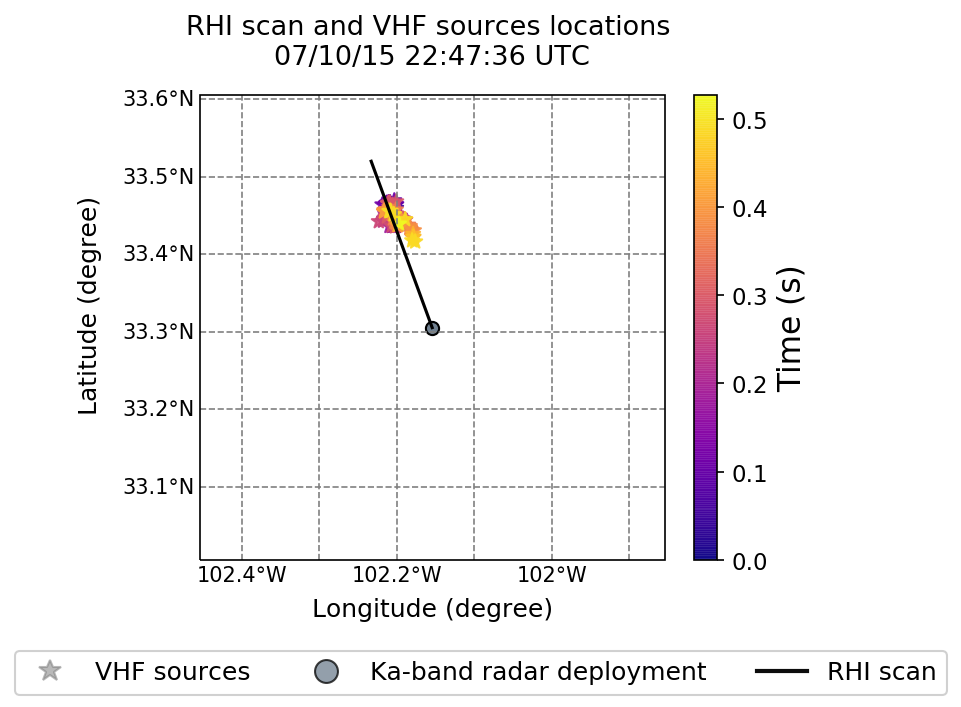

In [10]:
# - Visualize the VHF sources relative to the RHI scan
plot_locs_lma_rhi(radar, flash, 0.3)

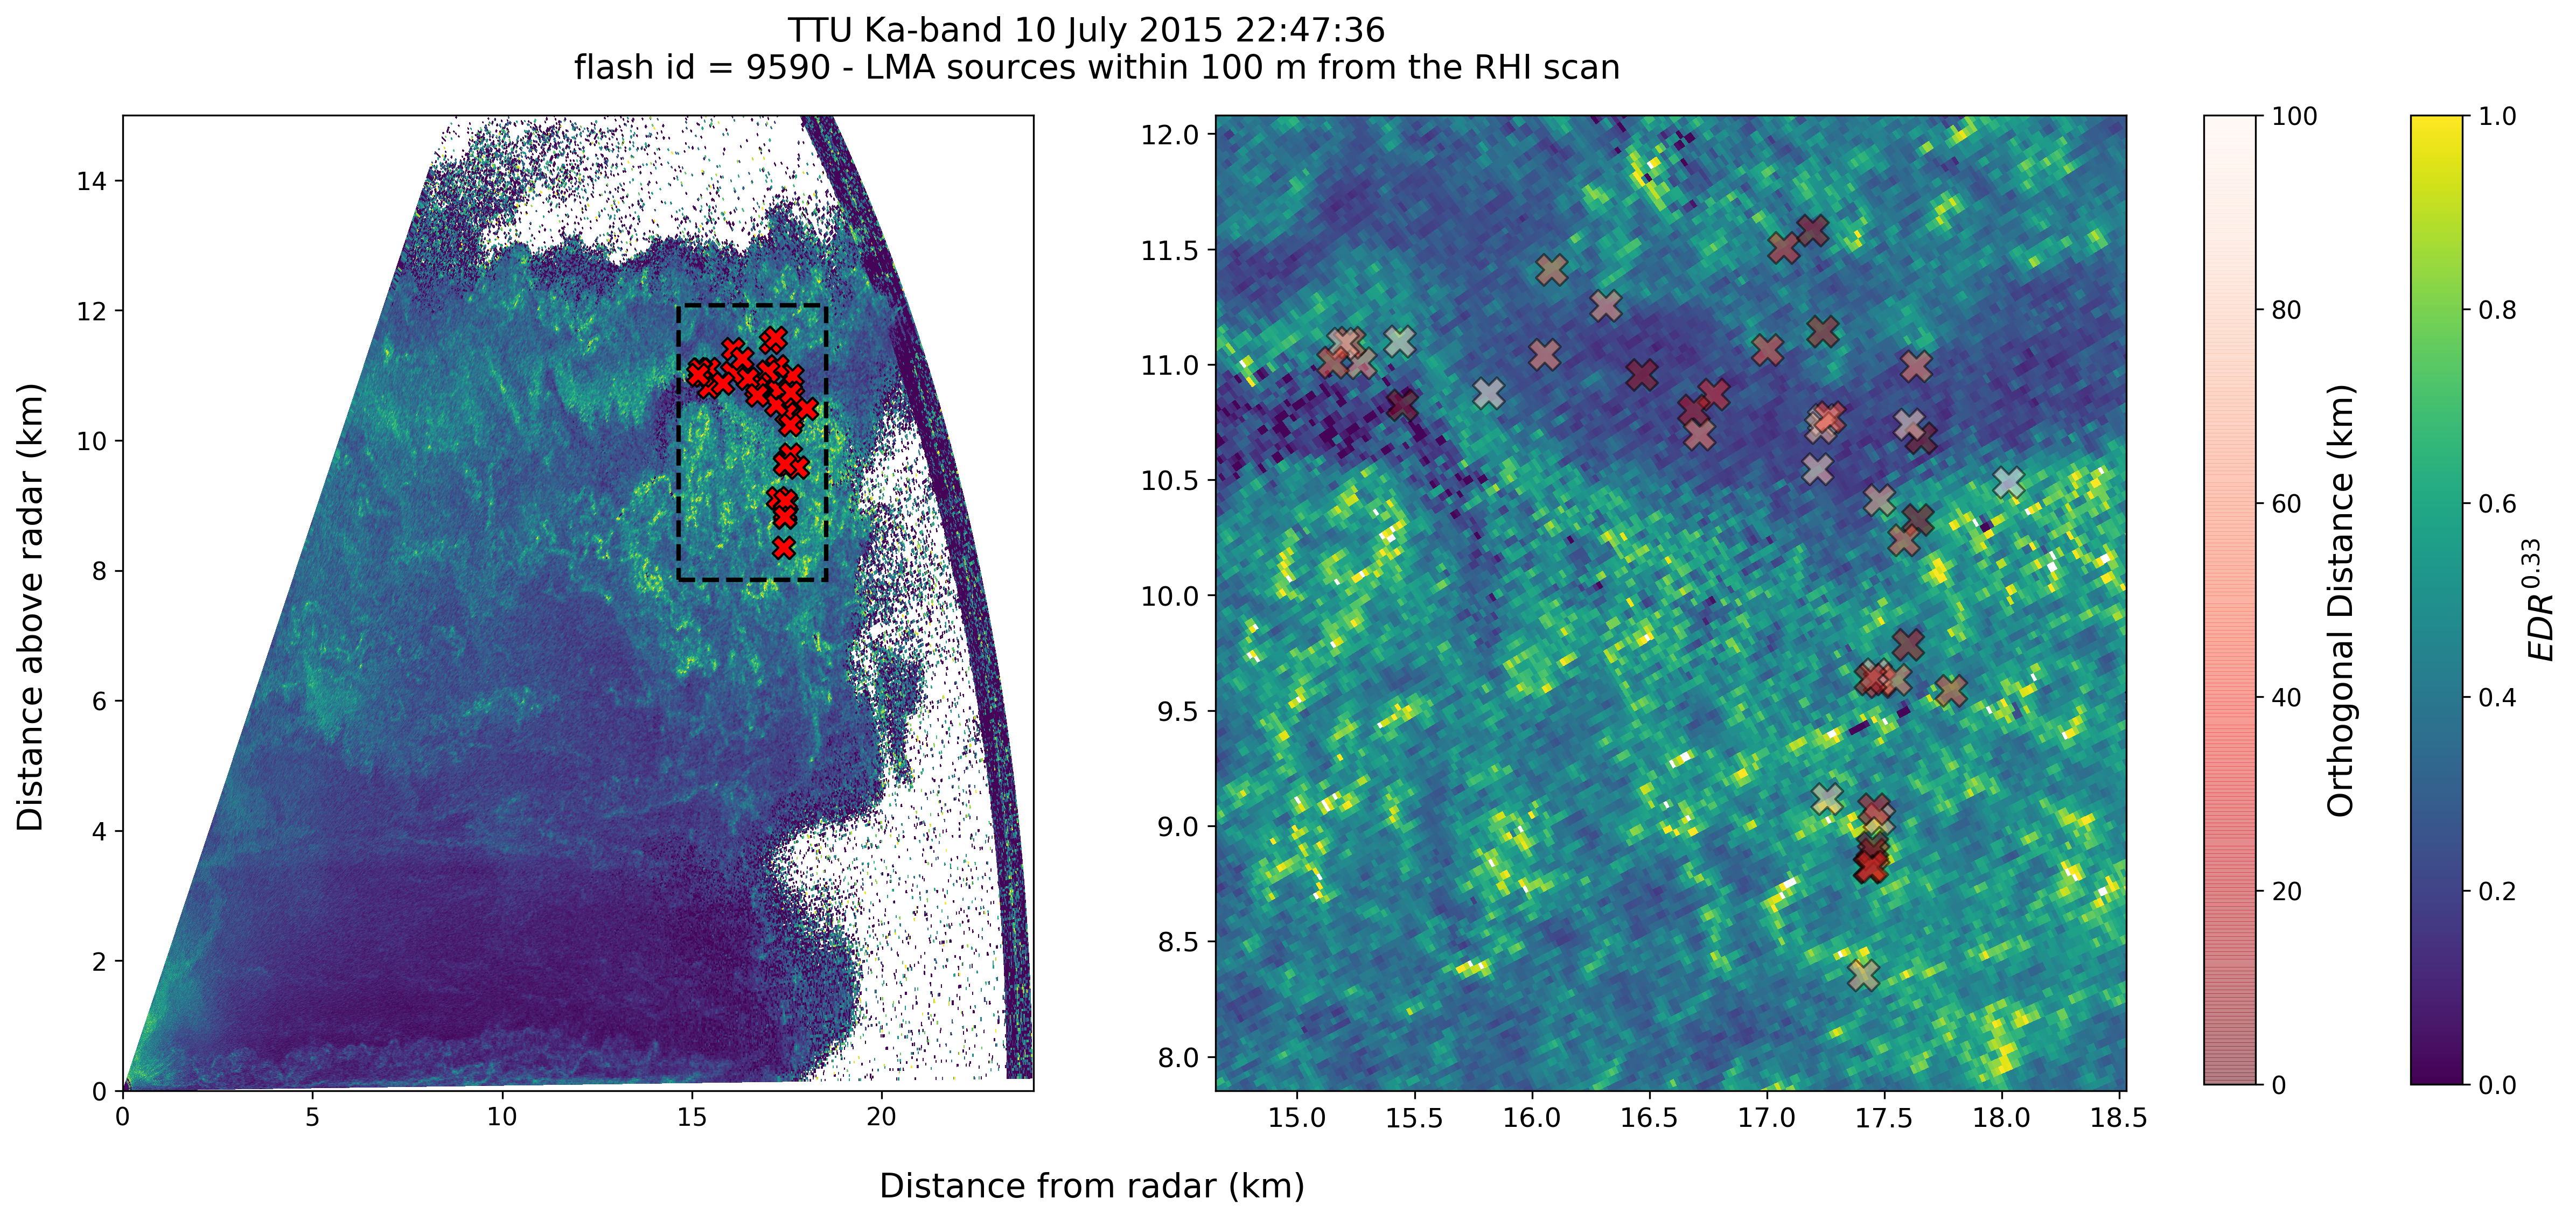

In [11]:
# - Visualize the RHI scan with EDR^0.33 and VHF sources within the threshold for flash #k
plot_RHI_EDR_panel(re/1000, ze/1000, values, R_cls/1000,  Z_cls/1000, Y_min, rmin, zmin, rmax, zmax, radar_time, flashes_id[k])

### 7. RETRIEVE RESULTS

In [12]:
##############
# ASSUME Y = 0 - real interception
int_point1 = [np.array([R_cls[i], 0 , Z_cls[i]]) for i in np.arange(R_cls.size)]

# 2o STEP
# Transform from Rotationed Coordinate system Tangent Plane to Tangent Plan (rotates clockwise = 1)
int_point2 = rot_mat_lma(radar, int_point1, 1)

# 3o STEP
# Tangent Plan to ECEF
int_point3 = [tps.fromLocal(int_point2[i,:][:,None]) for i in np.arange(R_cls.size)]

# 4o STEP
# Transform from ECEF to Radar Coordinate System
int_point4 = [rcs.fromECEF(int_point3[i][0],int_point3[i][1],int_point3[i][2]) for i in np.arange(R_cls.size)]

# 5o STEP
# Find closest point to RHI - Elevation and Range
cls_r_idx = [closest_pt_radarloc(radar, int_point4[i])[0]  for i in np.arange(R_cls.size)]
cls_az_idx = [closest_pt_radarloc(radar, int_point4[i])[1]  for i in np.arange(R_cls.size)]
cls_elev_idx = [closest_pt_radarloc(radar, int_point4[i])[2]  for i in np.arange(R_cls.size)]

# 6o STEP 
# Retrieve variables values for these point
# -- a) Nearest point
# -- b) barnes oban Rcut = 3*gate_spacing

delta = 100.
# --- Mean distance of gate centers at maximum range
sweep_idx = 0
rr_c, az_c, el_c = coords_2d(data = data, sweep_idx = sweep_idx, centers = True)
mean_distance_gate = 2 * np.sin(np.deg2rad((el_c[1:,-1] - el_c[:-1,-1]).mean())) * data.range.values.max()

# -- Specify cutoff radius / Search radius 
gate_spacing = radar.range['meters_between_gates']
gates = np.array([3*gate_spacing, mean_distance_gate])
Rcutoff = gates

intercep_nn = np.zeros((7,1))
intercep_oban1 = np.zeros((7,1))
intercep_oban2 = np.zeros((7,1))
weight_func = partial(barnes, k=0.5*(2*gate_spacing)**2)
# -- Radar Info to be stored
# Order: ['spectrum_width','turbulence','dVRdr', 'dVRde', 'vel_dealias']

for n in np.arange(R_cls.size):
    # -- Subset the raw data to only the points needed for interpolation
    index_range = np.where((r_c >= R_cls[n] - delta) & (r_c <= R_cls[n] + delta) & (z_c >= Z_cls[n] - delta) & (z_c <= Z_cls[n] + delta)  == True )
    points = np.vstack((r_c[index_range], z_c[index_range])).T
    xi = np.vstack((R_cls[n], Z_cls[n])).T
    
    # -- Initiatilizing the array
    intercep_nn_temp = np.zeros((7,1))
    intercep_oban1_temp = np.zeros((7,1))
    intercep_oban2_temp = np.zeros((7,1))
    
    for i, var in zip(np.arange(5),['spectrum_width','turbulence', 'dVRdr', 'dVRde', 'vel_dealias']):
        # - a)
        intercep_nn_temp[i] = np.ma.getdata(radar.fields[var]['data'])[cls_elev_idx[n], cls_r_idx[n]]
        ####
        values = data[var].values[index_range]
        # - b)
        intercep_oban1_temp[i] = oban(points, values, xi, weight_func = weight_func, search_radius = Rcutoff[0])
        intercep_oban2_temp[i] = oban(points, values, xi, weight_func = weight_func, search_radius = Rcutoff[1])
        

    # -- Lightning Info
    # - Storing the distances (from flash initiation and scan)
    intercep_nn_temp[-2] = np.sqrt((X1 - R_cls[n])**2 + (Y1)**2 + (Z1 - Z_cls[n])**2)
    intercep_nn_temp[-1] = abs(y_min[n])
    #
    intercep_oban1_temp[-2] = np.sqrt((X1 - R_cls[n])**2 + (Y1)**2 + (Z1 - Z_cls[n])**2)
    intercep_oban1_temp[-1] = abs(y_min[n])
    #
    intercep_oban2_temp[-2] = np.sqrt((X1 - R_cls[n])**2 + (Y1)**2 + (Z1 - Z_cls[n])**2)
    intercep_oban2_temp[-1] = abs(y_min[n])
    #
    intercep_nn = np.append(intercep_nn, intercep_nn_temp, axis = 1) 
    intercep_oban1 = np.append(intercep_oban1, intercep_oban1_temp, axis = 1)
    intercep_oban2 = np.append(intercep_oban2, intercep_oban2_temp, axis = 1)

flash_props = flashes[flashes.flash_id == flashes_id[k]]
# - delete collumn of zeros   
intercep_nn = np.delete(intercep_nn, [0], axis=1)
intercep_oban1 = np.delete(intercep_oban1, [0], axis=1)
intercep_oban2 = np.delete(intercep_oban2, [0], axis=1)
# - transpose var x itp
intercep_nn = intercep_nn.transpose()
intercep_oban1 = intercep_oban1.transpose()
intercep_oban2 = intercep_oban2.transpose()
# - Dataframe pandas with radar values for all points within the threshold
df_nn = pd.DataFrame(intercep_nn, columns = ['spectrum_width', 'turbulence','dVRdr', 'dVRde', 'vel_dealias', 'dist_1', 'dist_itp'])
df_oban1 = pd.DataFrame(intercep_oban1, columns = ['spectrum_width','turbulence','dVRdr', 'dVRde', 'vel_dealias', 'dist_1', 'dist_itp'])
df_oban2 = pd.DataFrame(intercep_oban2, columns = ['spectrum_width', 'turbulence','dVRdr', 'dVRde', 'vel_dealias', 'dist_1', 'dist_itp'])
# - Removing any bad points
df_nn = df_nn[df_nn.turbulence < 1.1]
df_oban1 = df_oban1[df_oban1.turbulence < 1.1]
df_oban2 = df_oban2[df_oban2.turbulence < 1.1]

In [13]:
# My weights goes from 1 (0 m distance) to 0.04 (100 m distance)
weights = sp.signal.gaussian(200, 40)[100:]

# - Mean, Weighted mean, standard deviation, weighted standard deviation for Nearest Neighbor
# - x = dist 1 source, y = turbulence
mean_nn, std_nn, wmean_nn, wstd_nn = interp_avg_std(df_nn)
# - Mean, Weighted mean, standard deviation, weighted standard deviation for barnes oban1
mean_oban1, std_oban1, wmean_oban1, wstd_oban1 = interp_avg_std(df_oban1)
# - Mean, Weighted mean, standard deviation, weighted standard deviation for barnes oban2
mean_oban2, std_oban2, wmean_oban2, wstd_oban2 = interp_avg_std(df_oban2)

### 8. VISUALIZE INDIVIDUAL RESULTS

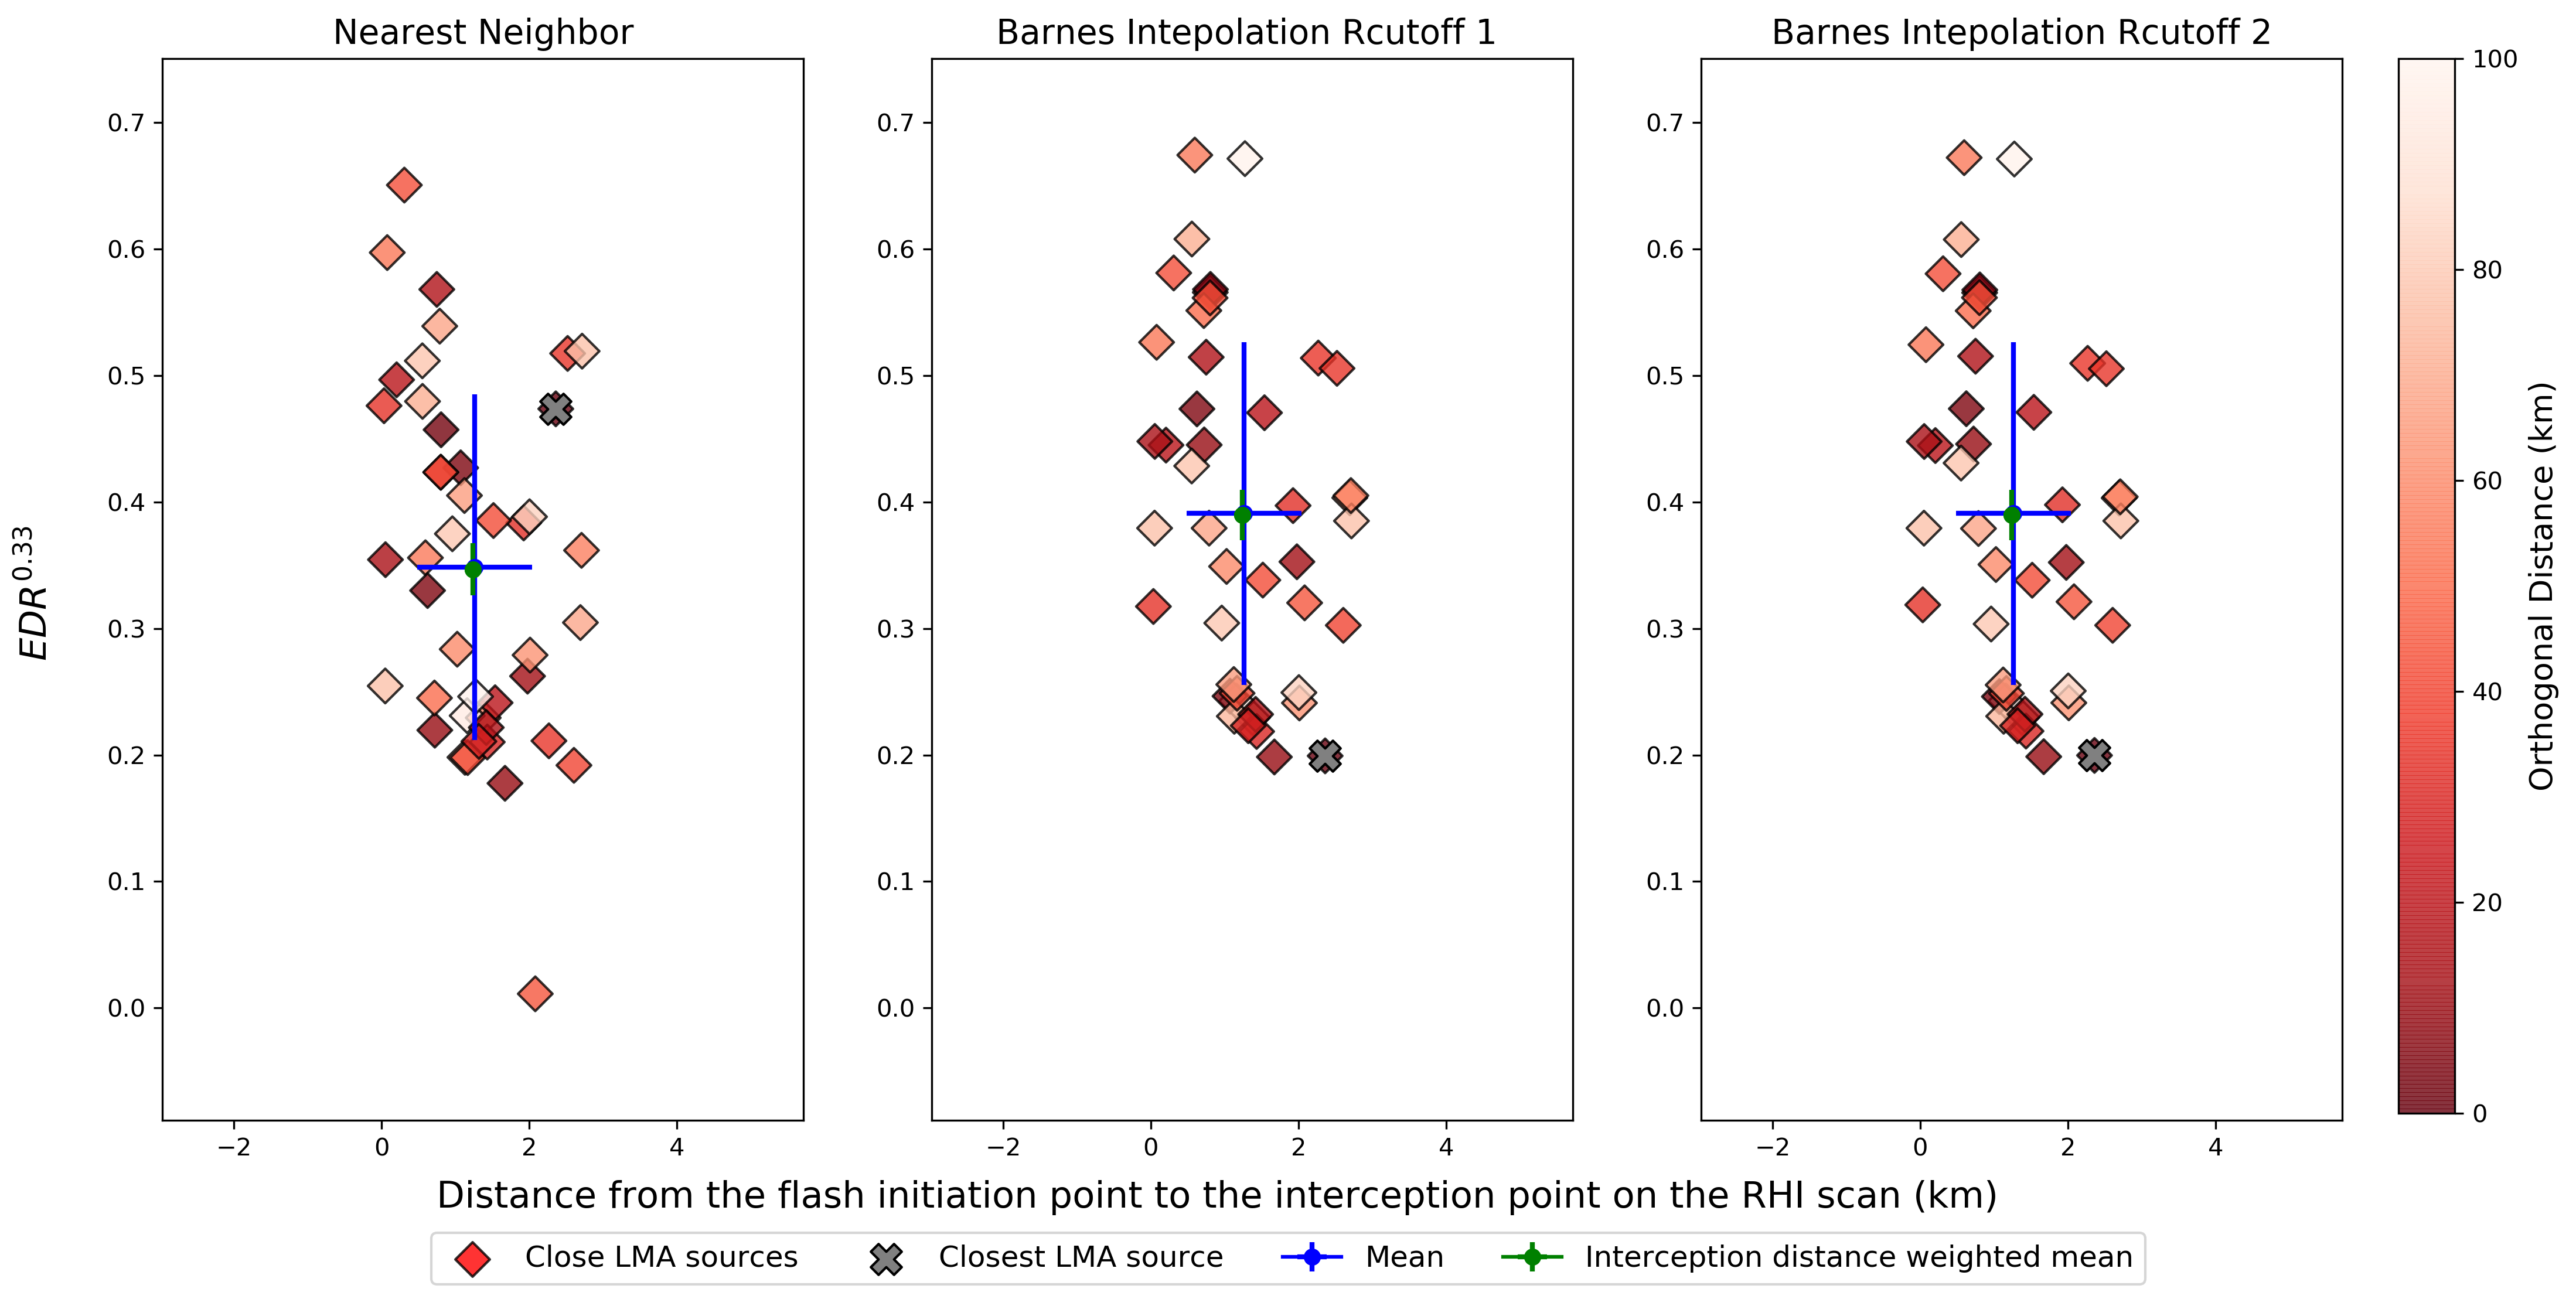

In [14]:
plot_sources_interp(df_nn, mean_nn[0], mean_nn[1], std_nn[0], std_nn[1], wmean_nn[0], wmean_nn[1], wstd_nn[0], wstd_nn[1],
                    df_oban1, mean_oban1[0], mean_oban1[1], std_oban1[0], std_oban1[1], wmean_oban1[0], wmean_oban1[1], wstd_oban1[0], wstd_oban1[1],
                    df_oban2, mean_oban2[0], mean_oban2[1], std_oban2[0], std_oban2[1], wmean_oban2[0], wmean_oban2[1], wstd_oban2[0],wstd_oban2[1])